## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [48]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cat ml-1m/README

--2025-02-22 08:49:14--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip.1’

ml-1m.zip.1         100%[===================>]   5.64M  3.28MB/s    in 1.7s    

2025-02-22 08:49:17 (3.28 MB/s) - ‘ml-1m.zip.1’ saved [5917549/5917549]

Archive:  ml-1m.zip
replace ml-1m/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be u

In [49]:
!pip install implicit optuna -q

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import optuna

from typing import Union
from scipy.sparse.linalg import svds
from scipy.sparse import coo_matrix, coo_array, csr_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
from implicit.als import AlternatingLeastSquares

In [51]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [52]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [53]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [54]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [55]:
user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [56]:
df_train['user_id'].nunique(), df_train['user_id'].max()

(5365, 5364)

In [57]:
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, 3009)

##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [58]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:
    interaction_matrix = df_train.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0)
    result = interaction_matrix.values
    return result

In [59]:
interactions = df_to_matrix(df_train)

In [60]:
# проверим корректность размера матрицы
assert interactions.shape[0] == 5365
assert interactions.shape[1] == 3010

In [61]:
interactions[:10, :10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 2., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [5., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [62]:
def df_to_coo(df: pd.DataFrame) -> coo_array:
    interaction_matrix = df_train.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0)
    matrix = interaction_matrix.values

    row_indices, col_indices = np.nonzero(matrix)
    values = matrix[row_indices, col_indices]

    result = coo_array((values, (row_indices, col_indices)), shape=matrix.shape)

    return result

In [63]:
coo_interactions = df_to_coo(df_train)

In [64]:
coo_interactions.toarray()[:10, :10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 2., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [5., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [65]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [66]:
def make_svd(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    # функция должна работать и для полной матрицы и для sparse матрицы(вам поможет isinstance).
    # если n_singular_values = -1, то берем все сингулярные числа для полной матрицы
    # и все кроме одного сингулярного числа для coo-матрицы(иначе scipy.sparse.linalg.svds не будет работать)

    if isinstance(interractions, np.ndarray):
        U, S, Vt = np.linalg.svd(interractions, full_matrices=False)
        if n_singular_values != -1:
            U = U[:, :n_singular_values]
            S = S[:n_singular_values]
            Vt = Vt[:n_singular_values, :]

    elif isinstance(interractions, coo_array):
        if n_singular_values == -1:
            n_singular_values = interractions.shape[1] - 1

        U, S, Vt = svds(interractions, k=n_singular_values)

    if n_singular_values != -1:
            U = U[:, :n_singular_values]
            S = S[:n_singular_values]
            Vt = Vt[:n_singular_values, :]

    return U, S, Vt

In [67]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ np.diag(S) @ V, interactions)

In [68]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ np.diag(S1) @ V1, U @ np.diag(S) @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [69]:
def make_svd_recommendations(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1, top_k: int = 100):
    # Возвращает матрицу вида n_users, top_k, то есть для каждого пользователя возвращаем индексы
    # top_k самых релевантный айтемов среди тех с которыми он еще не взаимодействовал

    U, S, Vt = make_svd(interractions, n_singular_values)

    predicted_ratings = np.dot(np.dot(U, np.diag(S)), Vt)

    n_users, n_items = predicted_ratings.shape

    recommendations = np.zeros((n_users, top_k), dtype=int)

    for user in range(n_users):
        interacted_items = np.where(interractions[user] > 0)[0]

        user_ratings = predicted_ratings[user]

        user_ratings[interacted_items] = -np.inf

        top_k_indices = np.argsort(user_ratings)[-top_k:][::-1]

        recommendations[user] = top_k_indices

    return recommendations #shape ~ [n_users, top_k]

In [70]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [71]:
def dcg(scores) :
    return np.sum(np.divide(np.power(2, scores) - 1,
                            np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64)

def ndcg_metric(gt_items, predicted):
    '''
    Функция для расчета NDGC
    '''
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg( relevance)
    if rank_dcg == 0.0:
        return 0.0
    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])
    if ideal_dcg == 0.0:
        return 0.0
    ndcg_ = rank_dcg / ideal_dcg
    return ndcg_

def evaluate_recommender(df, gt_col="test_interactions", predict_col='recs', topn=10):
    metric_values = []
    for idx, row in df.iterrows():
        gt_items = row[gt_col]
        model_preds = row[predict_col]
        metric_values.append((ndcg_metric(gt_items, model_preds)))
    return {"ndcg": np.mean(metric_values)}

In [72]:
# преобразуем матрицу рекомендаций в датафрейм с интеракциями, чтобы потом подтянуть их в тестовый датафрейм

user_ids = range(len(recs))
recs_df_grouped = pd.DataFrame({'user_id': user_ids})

recs_df_grouped['recs'] = [list(row) for row in recs]
recs_df_grouped.head()

,user_id,recs
0,0,"[1, 5, 2, 14, 20, 7, 12, 22, 28, 4, 27, 1542, ..."
1,1,"[5, 32, 18, 19, 1046, 29, 31, 30, 20, 878, 224..."
2,2,"[1, 17, 299, 10, 499, 942, 12, 242, 1307, 449,..."
3,3,"[10, 5, 1, 9, 23, 1610, 2241, 2237, 2607, 15, ..."
4,4,"[4, 2374, 28, 873, 215, 6, 24, 299, 1738, 2278..."


In [73]:
# создадим тестовый датафрейм
test_df_grouped = df_test.groupby('user_id').apply(lambda x: list(x['item_id']), include_groups=False).reset_index(name='test_interactions')
test_df_grouped.head()

,user_id,test_interactions
0,0,"[925, 926, 2992, 927, 936, 3004, 959, 670, 124..."
1,1,"[927, 928, 929, 933, 2278, 496, 2279, 2284, 30..."
2,3,"[925, 2995, 961, 1848, 839, 2780, 2399, 891]"
3,4,"[580, 665, 666, 1203, 510, 2097, 775, 47]"
4,6,"[1520, 2886, 1521, 934, 569, 2278, 935, 936, 4..."


In [74]:
# приджойним к тестовому датафрейму рекомендации

result_df = test_df_grouped.merge(recs_df_grouped[['user_id', 'recs']], on='user_id', how='left')
result_df.head()

,user_id,test_interactions,recs
0,0,"[925, 926, 2992, 927, 936, 3004, 959, 670, 124...","[1, 5, 2, 14, 20, 7, 12, 22, 28, 4, 27, 1542, ..."
1,1,"[927, 928, 929, 933, 2278, 496, 2279, 2284, 30...","[5, 32, 18, 19, 1046, 29, 31, 30, 20, 878, 224..."
2,3,"[925, 2995, 961, 1848, 839, 2780, 2399, 891]","[10, 5, 1, 9, 23, 1610, 2241, 2237, 2607, 15, ..."
3,4,"[580, 665, 666, 1203, 510, 2097, 775, 47]","[4, 2374, 28, 873, 215, 6, 24, 299, 1738, 2278..."
4,6,"[1520, 2886, 1521, 934, 569, 2278, 935, 936, 4...","[6, 7, 2168, 2029, 2045, 2579, 725, 2278, 12, ..."


In [75]:
# применим функцию прогноза
evaluate_recommender(result_df)

{'ndcg': 0.3357219306722853}

In [76]:
def plot_graphs(interractions: Union[np.ndarray, coo_array], test_df_grouped, top_k: int = 100):
    time_comp = {}
    ndcg = {}
    for n_singular_values in tqdm([1, 10, 50, 200, 1000], desc="Прогноз и расчет метрик"):
        time_start = time.time()
        recs = make_svd_recommendations(interactions, n_singular_values, 100)
        time_end = time.time()
        count_time = time_end - time_start
        time_comp[n_singular_values] = count_time
        user_ids = range(len(recs))
        recs_df_grouped = pd.DataFrame({'user_id': user_ids})
        recs_df_grouped[f'recs_{n_singular_values}'] = [list(row) for row in recs]
        result_df = test_df_grouped.merge(
            recs_df_grouped[['user_id', f'recs_{n_singular_values}']],
            on='user_id',
            how='left')
        ndcg[n_singular_values] = evaluate_recommender(result_df, predict_col=f'recs_{n_singular_values}').get('ndcg')
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Количество сингулярных значений')
    ax1.set_ylabel('Время выполнения (с)', color='tab:blue')
    ax1.plot(time_comp.keys(), time_comp.values(), color='tab:blue', marker='o', label='Время выполнения')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('NDCG', color='tab:red')
    ax2.plot(ndcg.keys(), ndcg.values(), color='tab:red', marker='x', label='NDCG')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title('Время выполнения и NDCG в зависимости от количества сингулярных значений')
    fig.tight_layout()
    plt.show()

Прогноз и расчет метрик:   0%|          | 0/5 [00:00<?, ?it/s]

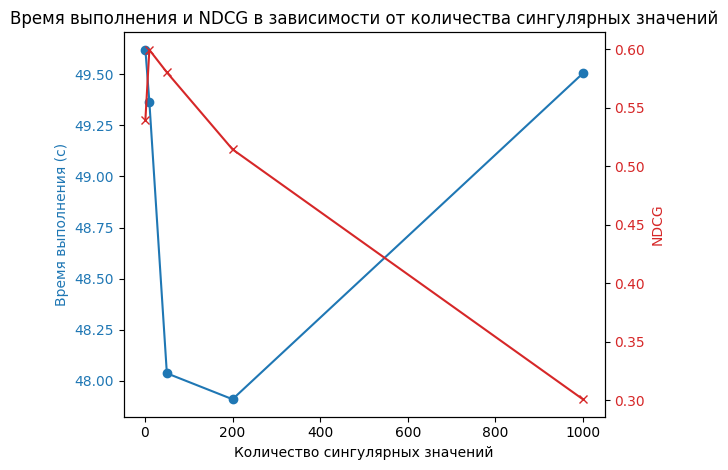

In [77]:
plot_graphs(interractions=coo_interactions,
            test_df_grouped=test_df_grouped)

Как видим из графика:
- при росте количества сингулярных значений происходит рост времени выполнения. В целом это логично, поскольку требуется больше вычислительных операций
- про росте количества сингулярных значений NDCG снижается. Это может быть связано с переобучением и включением менее важных данных и закономерностей по мере роста количества сингулярных значений

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [78]:
def make_als_recommendations(
    interactions: np.ndarray,
    top_k: int = 100,
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
):
    user_ids, item_ids = interactions.nonzero()
    ratings = interactions[user_ids, item_ids]

    coo_interactions = coo_matrix((ratings, (user_ids, item_ids)), shape=interactions.shape)

    csr_interactions = coo_interactions.tocsr()

    model = AlternatingLeastSquares(factors=n_factors, regularization=regularization, alpha=alpha)
    model.fit(csr_interactions)

    scores = model.recommend_all(csr_interactions, N=top_k)
    return scores

In [79]:
recs = make_als_recommendations(interactions=interactions)
assert recs.shape == (coo_interactions.shape[0], 100)

  0%|          | 0/15 [00:00<?, ?it/s]

In [80]:
# посчитаем точность

user_ids = range(len(recs))
recs_df_grouped_als = pd.DataFrame({'user_id': user_ids})

recs_df_grouped_als['recs_als'] = [list(row) for row in recs]
recs_df_grouped_als.head()

result_df_als = test_df_grouped.merge(recs_df_grouped_als[['user_id', 'recs_als']], on='user_id', how='left')
result_df_als.head()

,user_id,test_interactions,recs_als
0,0,"[925, 926, 2992, 927, 936, 3004, 959, 670, 124...","[670, 944, 684, 580, 665, 924, 2957, 262, 925,..."
1,1,"[927, 928, 929, 933, 2278, 496, 2279, 2284, 30...","[929, 944, 887, 685, 2278, 908, 898, 95, 812, ..."
2,3,"[925, 2995, 961, 1848, 839, 2780, 2399, 891]","[820, 432, 215, 3009, 854, 95, 399, 2699, 681,..."
3,4,"[580, 665, 666, 1203, 510, 2097, 775, 47]","[877, 2630, 878, 2806, 1038, 681, 968, 1394, 1..."
4,6,"[1520, 2886, 1521, 934, 569, 2278, 935, 936, 4...","[875, 889, 496, 1940, 877, 1982, 820, 1167, 20..."


In [81]:
evaluate_recommender(result_df_als, predict_col='recs_als')

{'ndcg': 0.5605803450523379}

Более высокую точность рекомендаций по метрике NDCG показывает метод ALS по сравнению с SVD.

In [82]:
# подбор гиперпараметров
def objective(trial):
    n_factors = trial.suggest_categorical('n_factors', [10, 20, 50, 100])
    alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
    regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)

    scores = make_als_recommendations(interactions, top_k=100, n_factors=n_factors, alpha=alpha, regularization=regularization)

    user_ids = range(len(recs))
    recs_df_grouped_als = pd.DataFrame({'user_id': user_ids})

    recs_df_grouped_als['recs_als'] = [list(row) for row in scores]
    recs_df_grouped_als.head()

    result_df_als = test_df_grouped.merge(recs_df_grouped_als[['user_id', 'recs_als']], on='user_id', how='left')
    score = evaluate_recommender(result_df_als, predict_col='recs_als').get('ndcg')

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2025-02-22 09:12:10,764] A new study created in memory with name: no-name-d86561de-c502-403a-b2a1-e477434b7646
<ipython-input-82-e1c04aa41690>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-82-e1c04aa41690>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-02-22 09:12:32,657] Trial 0 finished with value: 0.595610669213953 and parameters: {'n_factors': 10, 'alpha': 0.7659875515398341, 'regularization': 0.036625561563886855}. Best is trial 0 with value: 0.595610669213953.
<ipython-input-82-e1c04aa41690>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-82-e1c04aa41690>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-02-22 09:12:59,220] Trial 1 finished with value: 0.5720267552975441 and parameters: {'n_factors': 50, 'alpha': 0.19483123420672882, 'regularization': 0.01312073060254549}. Best is trial 0 with value: 0.595610669213953.
<ipython-input-82-e1c04aa41690>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-82-e1c04aa41690>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-02-22 09:13:21,802] Trial 2 finished with value: 0.5894395011454849 and parameters: {'n_factors': 10, 'alpha': 0.11063591518872605, 'regularization': 0.07341983104841678}. Best is trial 0 with value: 0.595610669213953.
<ipython-input-82-e1c04aa41690>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-82-e1c04aa41690>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-02-22 09:13:47,111] Trial 3 finished with value: 0.5878976164201158 and parameters: {'n_factors': 20, 'alpha': 0.3946595648877782, 'regularization': 0.019090680781082153}. Best is trial 0 with value: 0.595610669213953.
<ipython-input-82-e1c04aa41690>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-82-e1c04aa41690>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-02-22 09:14:12,303] Trial 4 finished with value: 0.5867731834118166 and parameters: {'n_factors': 20, 'alpha': 0.2960776037960073, 'regularization': 0.01027107912649917}. Best is trial 0 with value: 0.595610669213953.
<ipython-input-82-e1c04aa41690>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-82-e1c04aa41690>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-02-22 09:14:34,850] Trial 5 finished with value: 0.5949706495882713 and parameters: {'n_factors': 10, 'alpha': 1.7991124810964265, 'regularization': 0.012259344514640858}. Best is trial 0 with value: 0.595610669213953.
<ipython-input-82-e1c04aa41690>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-82-e1c04aa41690>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-02-22 09:15:00,225] Trial 6 finished with value: 0.552276257236075 and parameters: {'n_factors': 100, 'alpha': 0.19885534750046094, 'regularization': 0.40215434369245984}. Best is trial 0 with value: 0.595610669213953.
<ipython-input-82-e1c04aa41690>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-82-e1c04aa41690>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-02-22 09:15:23,004] Trial 7 finished with value: 0.5978671658163872 and parameters: {'n_factors': 10, 'alpha': 0.5162511051672403, 'regularization': 0.2843554947625666}. Best is trial 7 with value: 0.5978671658163872.
<ipython-input-82-e1c04aa41690>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-82-e1c04aa41690>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-02-22 09:15:45,329] Trial 8 finished with value: 0.5960642345587173 and parameters: {'n_factors': 10, 'alpha': 0.5212544127139962, 'regularization': 0.03306277310031587}. Best is trial 7 with value: 0.5978671658163872.
<ipython-input-82-e1c04aa41690>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-82-e1c04aa41690>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-02-22 09:16:10,721] Trial 9 finished with value: 0.5902104080076425 and parameters: {'n_factors': 20, 'alpha': 0.18125129440385665, 'regularization': 0.53006174849579}. Best is trial 7 with value: 0.5978671658163872.
<ipython-input-82-e1c04aa41690>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-82-e1c04aa41690>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-02-22 09:16:36,389] Trial 10 finished with value: 0.5551802069370116 and parameters: {'n_factors': 100, 'alpha': 1.1011462730473087, 'regularization': 0.24652454673277413}. Best is trial 7 with value: 0.5978671658163872.
<ipython-input-82-e1c04aa41690>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-82-e1c04aa41690>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-02-22 09:16:58,731] Trial 11 finished with value: 0.5986802362367624 and parameters: {'n_factors': 10, 'alpha': 0.6459896055453087, 'regularization': 0.12973639627010705}. Best is trial 11 with value: 0.5986802362367624.
<ipython-input-82-e1c04aa41690>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-82-e1c04aa41690>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-02-22 09:17:20,731] Trial 12 finished with value: 0.5961594118763669 and parameters: {'n_factors': 10, 'alpha': 0.70690632668229, 'regularization': 0.13708619420631254}. Best is trial 11 with value: 0.5986802362367624.
<ipython-input-82-e1c04aa41690>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-82-e1c04aa41690>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-02-22 09:17:47,227] Trial 13 finished with value: 0.5792466805070219 and parameters: {'n_factors': 50, 'alpha': 1.2727972436236359, 'regularization': 0.16170584700598736}. Best is trial 11 with value: 0.5986802362367624.
<ipython-input-82-e1c04aa41690>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-82-e1c04aa41690>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-02-22 09:18:09,852] Trial 14 finished with value: 0.598223563672862 and parameters: {'n_factors': 10, 'alpha': 0.5626476160605334, 'regularization': 0.9032943564976591}. Best is trial 11 with value: 0.5986802362367624.
<ipython-input-82-e1c04aa41690>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-82-e1c04aa41690>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-02-22 09:18:32,458] Trial 15 finished with value: 0.5966144844066599 and parameters: {'n_factors': 10, 'alpha': 0.7958739459901278, 'regularization': 0.6899352364047556}. Best is trial 11 with value: 0.5986802362367624.
<ipython-input-82-e1c04aa41690>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-82-e1c04aa41690>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-02-22 09:18:55,215] Trial 16 finished with value: 0.5976994691405757 and parameters: {'n_factors': 10, 'alpha': 0.34115541772708063, 'regularization': 0.07531165511580984}. Best is trial 11 with value: 0.5986802362367624.
<ipython-input-82-e1c04aa41690>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-82-e1c04aa41690>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-02-22 09:19:20,832] Trial 17 finished with value: 0.5532879424689056 and parameters: {'n_factors': 100, 'alpha': 1.2047467714794018, 'regularization': 0.9048158756323702}. Best is trial 11 with value: 0.5986802362367624.
<ipython-input-82-e1c04aa41690>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-82-e1c04aa41690>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-02-22 09:19:47,502] Trial 18 finished with value: 0.5769992933613363 and parameters: {'n_factors': 50, 'alpha': 0.2602678468190407, 'regularization': 0.04784066140878152}. Best is trial 11 with value: 0.5986802362367624.
<ipython-input-82-e1c04aa41690>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-82-e1c04aa41690>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-02-22 09:20:10,294] Trial 19 finished with value: 0.5966679744040387 and parameters: {'n_factors': 10, 'alpha': 0.5990834343109674, 'regularization': 0.21737018083607276}. Best is trial 11 with value: 0.5986802362367624.


In [83]:
print("Best Parameters:", study.best_params)
print("Best Score:", study.best_value)

Best Parameters: {'n_factors': 10, 'alpha': 0.6459896055453087, 'regularization': 0.12973639627010705}
Best Score: 0.5986802362367624


##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

In [84]:
# Для этого нам надо немного поменять метод обучения, чтобы он возвращал саму модель

def make_als_recommendations(
    interactions: np.ndarray,
    top_k: int = 100,
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
):
    user_ids, item_ids = interactions.nonzero()
    ratings = interactions[user_ids, item_ids]

    coo_interactions = coo_matrix((ratings, (user_ids, item_ids)), shape=interactions.shape)

    csr_interactions = coo_interactions.tocsr()

    model = AlternatingLeastSquares(factors=n_factors, regularization=regularization, alpha=alpha)
    model.fit(csr_interactions)

    scores = model.recommend_all(csr_interactions, N=top_k)
    return scores, model

Обучим для исследования модель с наилучшими гиперпараметрами

In [85]:
best_params = study.best_params

best_score, best_model = make_als_recommendations(
    interactions,
    top_k=100,
    n_factors=best_params['n_factors'],
    alpha=best_params['alpha'],
    regularization=best_params['regularization']
)

user_ids = range(len(recs))
recs_df_grouped_als = pd.DataFrame({'user_id': user_ids})

recs_df_grouped_als['recs_als'] = [list(row) for row in best_score]

result_df_als = test_df_grouped.merge(recs_df_grouped_als[['user_id', 'recs_als']], on='user_id', how='left')

evaluate_recommender(result_df_als, predict_col='recs_als')

  0%|          | 0/15 [00:00<?, ?it/s]

{'ndcg': 0.5980431127813006}

In [86]:
import chardet

with open("ml-1m/movies.dat", 'rb') as f:
    result = chardet.detect(f.read())
    print(result)

movies_df = pd.read_csv("ml-1m/movies.dat", sep='::', names=['movie_id', 'title', 'genres'], engine='python', encoding=result['encoding'])

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [41]:
movies_df.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [123]:
result_df_als['recs_als'].iloc[0][0]

670

In [106]:
movies_df[movies_df.movie_id == 671]

,movie_id,title,genres
665,671,Mystery Science Theater 3000: The Movie (1996),Comedy|Sci-Fi


1. Попробуем понять почему пользователю 0 был порекомендован комедийный фантастический фильм Mystery Science Theater 3000

In [122]:
"""
explain(userid, user_items, itemid, user_weights=None, N=10)
  Provides explanations for why the item is liked by the user.

Parameters
    userid (int) – The userid to explain recommendations for
    user_items (csr_matrix) – Sparse matrix containing the liked items for the user
    itemid (int) – The itemid to explain recommendations for
    user_weights (ndarray, optional) – Precomputed Cholesky decomposition of the weighted user liked items. Useful for speeding up repeated calls to this function, this value is returned
    N (int, optional) – The number of liked items to show the contribution for
Returns
    total_score (float) – The total predicted score for this user/item pair
    top_contributions (list) – A list of the top N (itemid, score) contributions for this user/item pair
    user_weights (ndarray) – A factorized representation of the user. Passing this in to future ‘explain’ calls will lead to noticeable speedups
"""


user_items_0 = csr_matrix(interactions[0, :])
user_id_0 = 0
itemid_0 = 0
best_model.explain(user_id_0, user_items_0, itemid_0)

(0.2850948225620718,
 [(846, 0.03750550303485712),
  (510, 0.033628272480324746),
  (674, 0.023596351927803138),
  (681, 0.022263722184448765),
  (2168, 0.021859616175409904),
  (2119, 0.020804793544798868),
  (449, 0.019758102174561316),
  (685, 0.01666835719771661),
  (886, 0.015937368776492315),
  (567, 0.015737755275523464)],
 (array([[ 2.93307684e+00, -2.41521505e-01, -2.34684760e-01,
          -3.00691250e-01,  4.54751574e-01,  2.30234423e-03,
          -1.05130308e+00, -5.11464915e-01, -5.21257224e-02,
          -2.02050390e-01],
         [-7.08401131e-01,  2.71052767e+00, -3.88390261e-01,
          -4.92925031e-01, -6.71312206e-02,  3.33356340e-02,
           1.66820934e-01, -1.48570500e-01, -8.47333642e-02,
          -4.64493339e-02],
         [-6.88348435e-01, -9.96061133e-01,  2.84787134e+00,
           4.17611948e-01, -5.05191113e-01, -7.85467378e-01,
          -5.31297825e-01, -1.47765938e-01, -3.78749596e-01,
          -4.91501149e-01],
         [-8.81950542e-01, -1.26346

In [115]:
movies_df[movies_df.movie_id == 847]

,movie_id,title,genres
836,847,"Big Squeeze, The (1996)",Comedy|Drama


In [119]:
movies_df[movies_df.movie_id == 511]

,movie_id,title,genres
507,511,"Program, The (1993)",Action|Drama


In [120]:
movies_df[movies_df.movie_id == 675]

,movie_id,title,genres
669,675,Hostile Intentions (1994),Action|Drama|Thriller


Наибольшее влияние на рекомендацию оказали фильмы:  
- Big Squeeze - комедия, драма
- Program - экшн, драма
- Hostile Intentions - экшн, драма, триллер  
Все три фильма - фильмы середины 90-х годов, т.е. похожи на рекомендованный фильм, один из них имеет комедийный жанр что соответствует рекомендованному. В целом экшн и фантастика тоже часто пересекаются. Логика рекомендации понятна

In [124]:
result_df_als['recs_als'].iloc[2][0]

16

In [125]:
movies_df[movies_df.movie_id == 17]

,movie_id,title,genres
16,17,Sense and Sensibility (1995),Drama|Romance


2. Попробуем понять почему пользователю 2 был порекомендован романтический драматический фильм Sense and Sensibility.

In [132]:
user_items_2 = csr_matrix(interactions[2, :])
best_model.explain(0, user_items_2, itemid=0)

(0.36207631801704254,
 [(1497, 0.029736266769441664),
  (211, 0.024569642449293792),
  (381, 0.02456597714299245),
  (94, 0.023929518195239884),
  (877, 0.02293487349531088),
  (638, 0.02199688963033602),
  (2119, 0.02006646595793795),
  (959, 0.01864579549444462),
  (936, 0.017310057651014517),
  (774, 0.016539006287667964)],
 (array([[ 2.90260027, -0.25545193, -0.15717834, -0.19429131,  0.30723396,
          -0.08907246, -1.03921001, -0.51042917, -0.20796993, -0.19049424],
         [-0.74147485,  2.74014724, -0.42711712, -0.53881712, -0.03854184,
           0.11230715,  0.21319916, -0.16243248, -0.10801046, -0.08657631],
         [-0.45622588, -1.13021228,  2.9961842 ,  0.43017091, -0.57304309,
          -1.07501709, -0.67421989, -0.12039008, -0.35510449, -0.40460881],
         [-0.56395001, -1.42680616,  1.54954769,  3.02748854, -0.73908703,
          -0.8430043 , -0.30845949,  0.08786025, -0.47668805, -0.41702849],
         [ 0.89177737, -0.18409382, -1.74877129, -2.52300986,  3.02

In [133]:
movies_df[movies_df.movie_id == 1498]

,movie_id,title,genres
1466,1498,Inventing the Abbotts (1997),Drama|Romance


In [135]:
movies_df[movies_df.movie_id == 212]

,movie_id,title,genres
210,212,Bushwhacked (1995),Comedy


In [140]:
movies_df[movies_df.movie_id == 382]

,movie_id,title,genres
378,382,Wolf (1994),Drama|Horror


В принципе мы видим, что фильм, внесший наибольший вклад в рекомендацию имеет похожий год выпуска (1997) и аналогичный жанр (романтическая драма). Любопытно, что второй и третий по вкладу в рекомендацию фильм - это достаточно далекие от романтики жанры (комедия и драматический хоррор), однако имеют похожие года выпуска (1994 и 1995).

##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

In [ ]:
#your code here

##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [ ]:
class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef = 0.01):
        #your code here

    def fit(self, interractions: np.ndarray, n_iterations: int 10):
        #your code here

    def predict(self, top_k: int = 100):
        # возвращает top-k айтемов для каждого юзера(айтемы с которыми юзер взаимодействовал не должны попасть в рекомендации)
        #your code here

        return predicts # shape ~ [n_users, top_k]